In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset
(cifar_train_images, cifar_train_labels), (cifar_test_images, cifar_test_labels) = tf.keras.datasets.cifar10.load_data()
cifar_train_images = cifar_train_images[:1000] / 255.0
cifar_train_labels = cifar_train_labels[:1000]
cifar_test_images = cifar_test_images[:200] / 255.0
cifar_test_labels = cifar_test_labels[:200]

# Model
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
base_model = hub.KerasLayer(model_url, trainable=True)
model_tf = tf.keras.Sequential([base_model, tf.keras.layers.Dense(10, activation='softmax')])
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_tf.fit(cifar_train_images, cifar_train_labels, epochs=8, validation_data=(cifar_test_images, cifar_test_labels))

# Predictions
tf_predictions = model_tf.predict(cifar_test_images)
tf_predicted_classes = np.argmax(tf_predictions, axis=1)


170498071/170498071 [==============================] - 3s 0us/step
Epoch 1/8
32/32 [==============================] - 33s 333ms/step - loss: 6.1474 - accuracy: 0.1200 - val_loss: 2.3134 - val_accuracy: 0.1150
Epoch 2/8
32/32 [==============================] - 9s 288ms/step - loss: 2.3583 - accuracy: 0.1520 - val_loss: 2.3090 - val_accuracy: 0.1550
Epoch 3/8
32/32 [==============================] - 9s 290ms/step - loss: 2.1802 - accuracy: 0.2270 - val_loss: 2.2518 - val_accuracy: 0.1650
Epoch 4/8
32/32 [==============================] - 9s 286ms/step - loss: 1.8493 - accuracy: 0.3160 - val_loss: 1.9926 - val_accuracy: 0.2300
Epoch 5/8
32/32 [==============================] - 9s 288ms/step - loss: 1.3653 - accuracy: 0.4730 - val_loss: 1.7764 - val_accuracy: 0.4000
Epoch 6/8
32/32 [==============================] - 9s 288ms/step - loss: 1.1236 - accuracy: 0.5690 - val_loss: 1.8480 - val_accuracy: 0.4350
Epoch 7/8
32/32 [==============================] - 9s 289ms/step - loss: 0.9061 - accu

In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
 

In [10]:
!pip install transformers

In [12]:
from datasets import load_dataset
from transformers import TFAutoModel, AutoTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import numpy as np

# Dataset
dataset = load_dataset('glue', 'sst2')
train_dataset = dataset['train'].select(range(500))
test_dataset = dataset['validation'].select(range(100))
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
train_encodings = tokenizer(train_dataset['sentence'], truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_dataset['sentence'], truncation=True, padding=True, max_length=128)

# Convert to TensorFlow datasets
train_dataset_tf = tf.data.Dataset.from_tensor_slices((dict(train_encodings), train_dataset['label'])).shuffle(1000).batch(16)
test_dataset_tf = tf.data.Dataset.from_tensor_slices((dict(test_encodings), test_dataset['label'])).batch(16)

# Model
model_hf = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Define optimizer and loss outside compile
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Compile using a custom training step
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model_hf(inputs, training=True)
        loss = loss_fn(labels, predictions.logits)
    gradients = tape.gradient(loss, model_hf.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_hf.trainable_variables))
    return loss, predictions.logits

# Training loop
epochs = 3
for epoch in range(epochs):
    for inputs, labels in train_dataset_tf:
        loss, logits = train_step(inputs, labels)
        # Print or log the loss

# Predictions
hf_predictions = model_hf.predict(test_dataset_tf).logits
hf_predicted_classes = np.argmax(hf_predictions, axis=1)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


7/7 [==============================] - 11s 365ms/step


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [14]:
# Install the Kaggle API client
!pip install -q kaggle

# Upload the kaggle.json file
from google.colab import files
files.upload()

# Set up the directory and file permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download a sample dataset (for example, the Titanic dataset)
!kaggle competitions download -c titanic

# Unzip the dataset
!unzip titanic.zip


Saving titanic.zip to titanic.zip
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.10/dist-packages/kaggle/__init__.py", line 7, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.10/dist-packages/kaggle/api/kaggle_api_extended.py", line 407, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Archive:  titanic.zip
  inflating: Titanic-Dataset.csv     


In [15]:
# Download the Iris dataset
!kaggle datasets download -d uciml/iris

# Unzip the dataset
!unzip iris.zip

# Load the dataset using pandas
import pandas as pd

data = pd.read_csv('Iris.csv')

Dataset URL: https://www.kaggle.com/datasets/uciml/iris
License(s): CC0-1.0
  0% 0.00/3.60k [00:00<?, ?B/s]
100% 3.60k/3.60k [00:00<00:00, 9.57MB/s]
Archive:  iris.zip
  inflating: Iris.csv                
  inflating: database.sqlite         


In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Dataset
data = pd.read_csv('Iris.csv')
data = data.drop('Id', axis=1)
le = LabelEncoder()
data['Species'] = le.fit_transform(data['Species'])
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
X_train = train_data.drop('Species', axis=1)
y_train = train_data['Species']
X_test = test_data.drop('Species', axis=1)
y_test = test_data['Species']

# Model
model_kg = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])
model_kg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_kg.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test))

# Predictions
kg_predictions = model_kg.predict(X_test)
kg_predicted_classes = np.argmax(kg_predictions, axis=1)


Epoch 1/50
12/12 [==============================] - 1s 16ms/step - loss: 1.7377 - accuracy: 0.3417 - val_loss: 1.5900 - val_accuracy: 0.3000
Epoch 2/50
12/12 [==============================] - 0s 5ms/step - loss: 1.3963 - accuracy: 0.3417 - val_loss: 1.3352 - val_accuracy: 0.3000
Epoch 3/50
12/12 [==============================] - 0s 5ms/step - loss: 1.2605 - accuracy: 0.4250 - val_loss: 1.2182 - val_accuracy: 0.4333
Epoch 4/50
12/12 [==============================] - 0s 5ms/step - loss: 1.1830 - accuracy: 0.4833 - val_loss: 1.1516 - val_accuracy: 0.4667
Epoch 5/50
12/12 [==============================] - 0s 5ms/step - loss: 1.1239 - accuracy: 0.5083 - val_loss: 1.0929 - val_accuracy: 0.5667
Epoch 6/50
12/12 [==============================] - 0s 5ms/step - loss: 1.0671 - accuracy: 0.4917 - val_loss: 1.0368 - val_accuracy: 0.5667
Epoch 7/50
12/12 [==============================] - 0s 5ms/step - loss: 1.0146 - accuracy: 0.5500 - val_loss: 0.9839 - val_accuracy: 0.5333
Epoch 8/50
12/12 [=

In [17]:
# Accuracies
tf_accuracy = np.mean(tf_predicted_classes == cifar_test_labels[:, 0])
hf_accuracy = np.mean(hf_predicted_classes == test_dataset['label'])
kg_accuracy = np.mean(kg_predicted_classes == y_test.values)

print(f"TensorFlow Model Accuracy (CIFAR-10): {tf_accuracy:.2f}")
print(f"HuggingFace Model Accuracy (SST-2): {hf_accuracy:.2f}")
print(f"Kaggle Model Accuracy (Iris): {kg_accuracy:.2f}")


TensorFlow Model Accuracy (CIFAR-10): 0.42
HuggingFace Model Accuracy (SST-2): 0.86
Kaggle Model Accuracy (Iris): 1.00


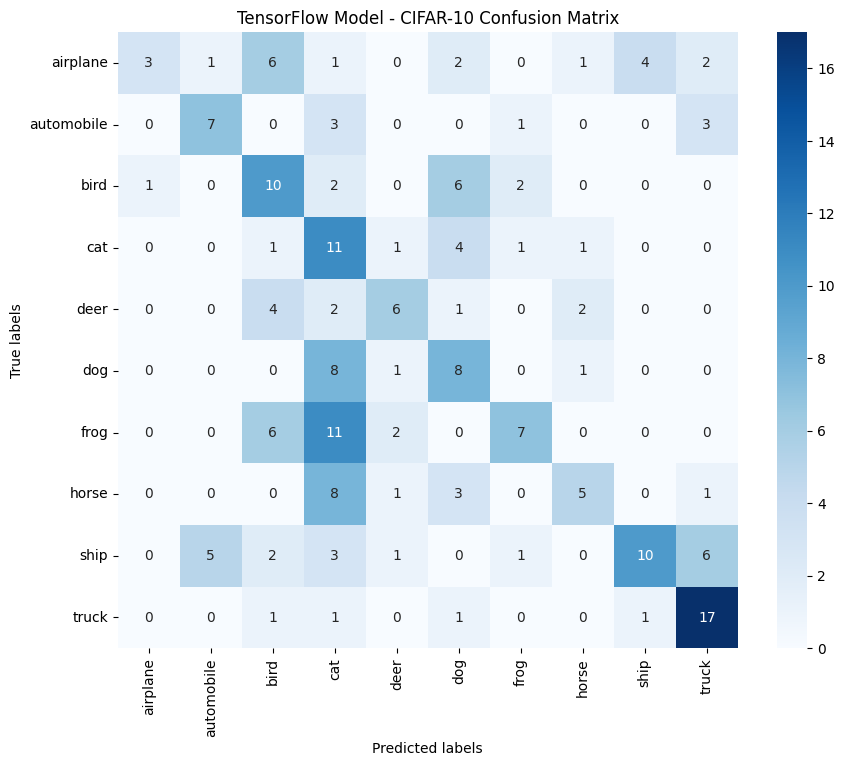

In [18]:
# TensorFlow Model - CIFAR-10 Dataset
tf_cm = confusion_matrix(cifar_test_labels, tf_predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(tf_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], yticklabels=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('TensorFlow Model - CIFAR-10 Confusion Matrix')
plt.show()


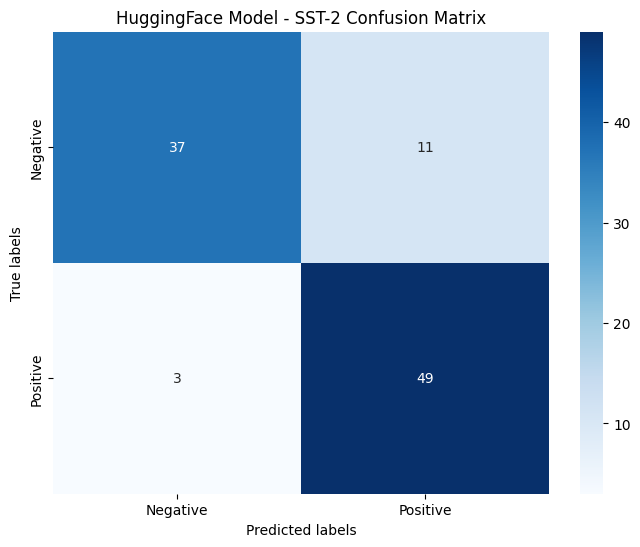

In [19]:
# HuggingFace Model - SST-2 Dataset
hf_cm = confusion_matrix(test_dataset['label'], hf_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(hf_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('HuggingFace Model - SST-2 Confusion Matrix')
plt.show()


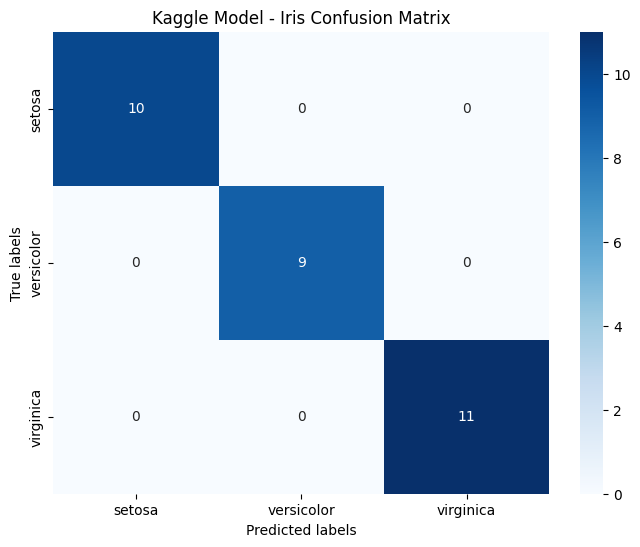

In [20]:
# Kaggle Model - Iris Dataset
kg_cm = confusion_matrix(y_test, kg_predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(kg_cm, annot=True, fmt='g', cmap='Blues', xticklabels=['setosa', 'versicolor', 'virginica'], yticklabels=['setosa', 'versicolor', 'virginica'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Kaggle Model - Iris Confusion Matrix')
plt.show()
